# Hilda's Place- 24 Hour Load Profile Calculation

Author: Mercy Masanga
Date: 24 November 2025

DESCRIPTION:
------------
This script calculates the 24-hour electrical load profile for Hilda's Place, a building
consisting of two apartments and one penthouse, using the appliance and lighting data
provided in an Excel workbook. It also plots the hourly load profiles for each apartment,
for each category of appliances, and for the entire building.

INPUT DATA:
-----------
- Excel file: 'Building_Apartment_Data.xlsx'
- Each sheet represents one dwelling (Apartment 1, Apartment 2, Penthouse)
- Columns expected in each sheet:
    Floor, Item, Power_W, Quantity, Operating_Hours, Start_Hour, Category

ASSUMPTIONS:
------------
1. Appliances operate according to the provided Operating_Hours and Start_Hour.
   - Start_Hour = 0 is interpreted as operating from hour 0 (midnight) for 24 hours if Operating_Hours = 24.
2. Appliances with 24-hour operation have their power evenly distributed across all 24 hours.
3. A constant standby load is added to the building to account for:
   - Occasional unplanned usage of lights or appliances not captured in the data
   - Continuous small loads like fridges, freezers, or alarms
   - Default standby load is 1 kW, applied uniformly across all hours.
4. Loads are summed per category (Lighting, Appliances, Alarm, Standby) for further analysis.
5. Power values are converted from W to kW for all calculations.
6. Hourly load profiles are discrete by nature; any smoothing for plots is for visualisation only.

OUTPUT:
-------
- Hourly load profile per apartment
- Hourly load profile per category (building-wide)
- Total building 24-hour load profile
- Matplotlib plots showing the profiles

NOTES:
------
- This script is intended for **off-grid design calculations**, including sizing
  of solar PV and battery systems.
- For technical calculations, the actual step-wise hourly load should be used,
  not the smoothed curves, which are for presentation purposes.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# -----------------------------
# SETTINGS
# -----------------------------
excel_file = 'Building_Apartment_Data.xlsx'  # your Excel file
standby_load_kw = 1.0  # standby load for unplanned usage

# Read all sheets
sheets = pd.read_excel(excel_file, sheet_name=None)

# -----------------------------
# INITIALIZE DICTIONARIES
# -----------------------------
profiles = {}           # hourly profile per apartment
category_profiles = {}  # hourly profile per category per apartment

# -----------------------------
# FUNCTION TO CREATE 24-HOUR PROFILE
# -----------------------------
def create_hourly_profile(df, standby_load_kw=0):
    hourly_profile = np.zeros(24)
    category_dict = {}

    categories = df['Category'].unique()
    for cat in categories:
        category_dict[cat] = np.zeros(24)

    for _, row in df.iterrows():
        total_power = row['Power_W'] * row['Quantity']  # W
        hours = row['Operating_Hours']
        start = row['Start_Hour']
        cat = row['Category']

        if hours == 24:
            hourly_profile += total_power / 24
            category_dict[cat] += total_power / 24
        else:
            for h in range(int(hours)):
                hour_index = (int(start) + h) % 24
                hourly_profile[hour_index] += total_power
                category_dict[cat][hour_index] += total_power

    # Convert to kW
    hourly_profile = hourly_profile / 1000
    for cat in category_dict:
        category_dict[cat] = category_dict[cat] / 1000

    # Add standby load
    if standby_load_kw > 0:
        hourly_profile += standby_load_kw
        if 'Standby' not in category_dict:
            category_dict['Standby'] = np.zeros(24)
        category_dict['Standby'] += standby_load_kw

    return hourly_profile, category_dict

# -----------------------------
# PROCESS SHEETS
# -----------------------------
for sheet_name, df in sheets.items():
    hourly_profile, cat_dict = create_hourly_profile(df, standby_load_kw=standby_load_kw)
    profiles[sheet_name] = hourly_profile
    category_profiles[sheet_name] = cat_dict

# -----------------------------


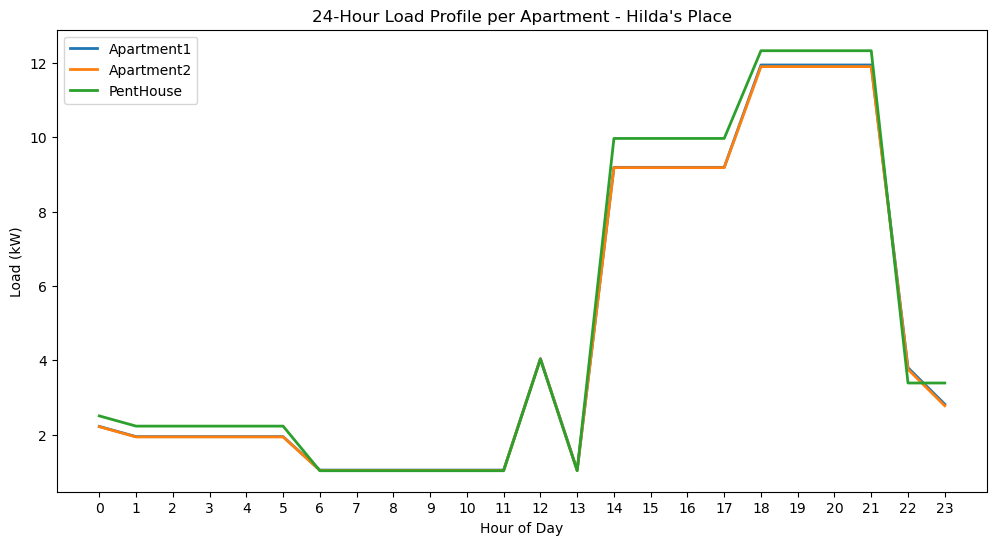

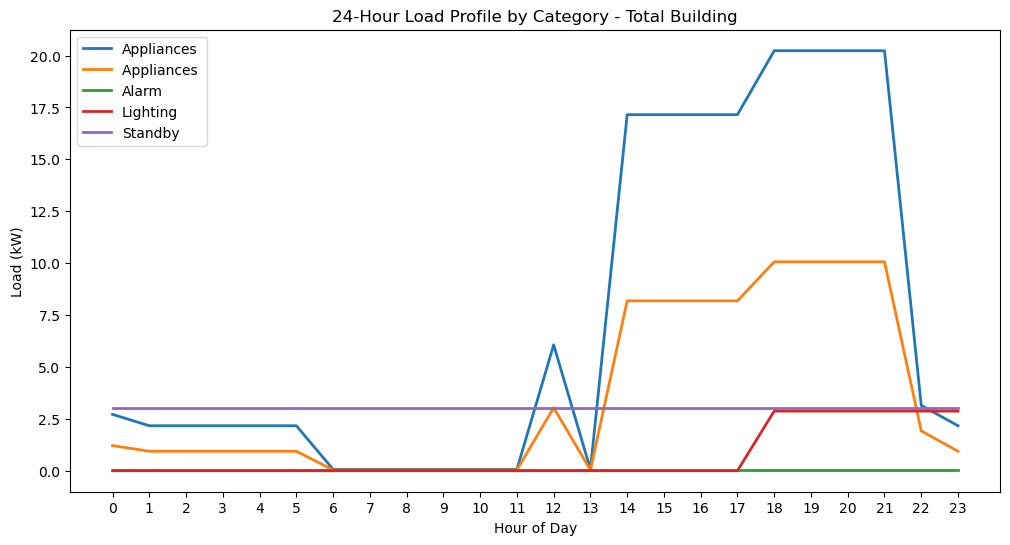

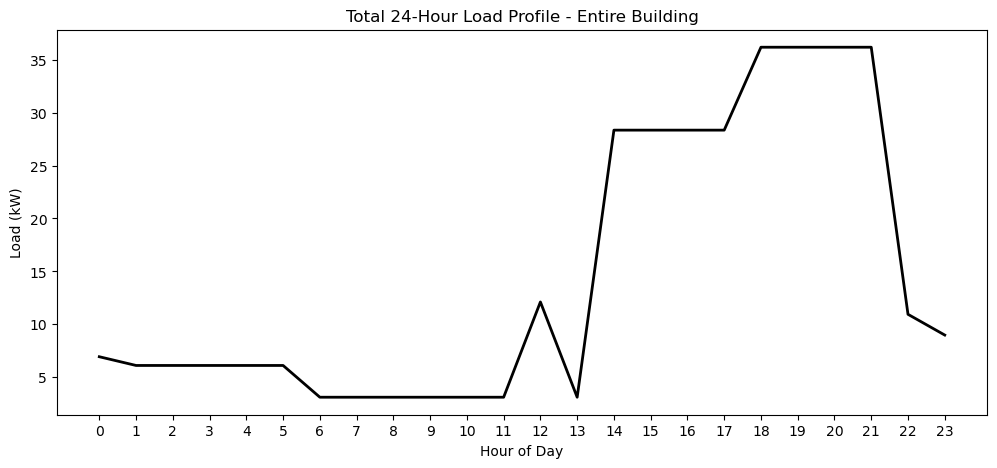

In [3]:
# -----------------------------
# CALCULATE TOTAL CATEGORY AND BUILDING PROFILES
# -----------------------------
# Total profile per category across all apartments
all_categories = set()
for apt_cats in category_profiles.values():
    all_categories.update(apt_cats.keys())

total_category_profile = {cat: np.zeros(24) for cat in all_categories}

for apt_cats in category_profiles.values():
    for cat, profile in apt_cats.items():
        total_category_profile[cat] += profile

# Total building profile (sum of all apartments)
total_building_profile = sum(profiles.values())

# -----------------------------
# PLOT LOAD PROFILES PER APARTMENT
# -----------------------------
plt.figure(figsize=(12,6))
for apt_name, profile in profiles.items():
    plt.plot(range(24), profile, label=apt_name, linewidth=2)  
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.title('24-Hour Load Profile per Apartment - Hilda\'s Place')
plt.grid(False)  # remove grid boxes
plt.xticks(range(24))
plt.legend()
plt.show()

# -----------------------------
# PLOT LOAD PROFILES PER CATEGORY (total building)
# -----------------------------
plt.figure(figsize=(12,6))
for cat, profile in total_category_profile.items():
    plt.plot(range(24), profile, label=cat, linewidth=2) 
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.title('24-Hour Load Profile by Category - Total Building')
plt.grid(False)
plt.xticks(range(24))
plt.legend()
plt.show()

# -----------------------------
# TOTAL BUILDING PROFILE
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(range(24), total_building_profile, color='black', linewidth=2)  
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.title('Total 24-Hour Load Profile - Entire Building')
plt.grid(False)  
plt.xticks(range(24))
plt.show()


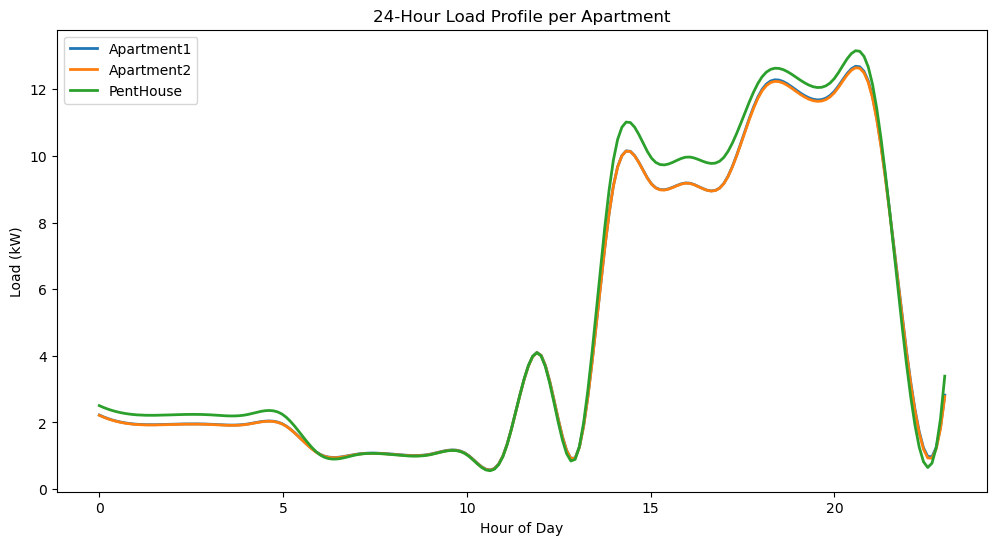

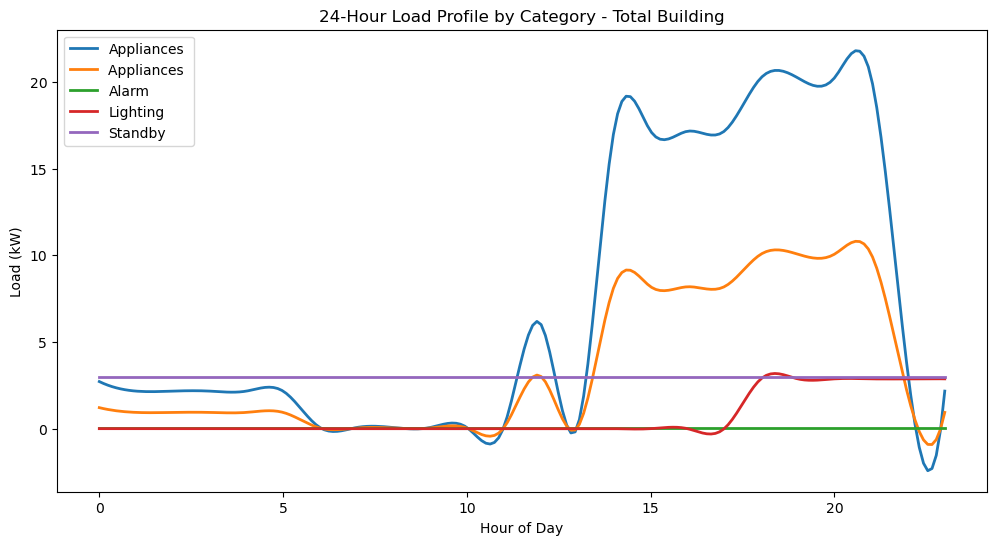

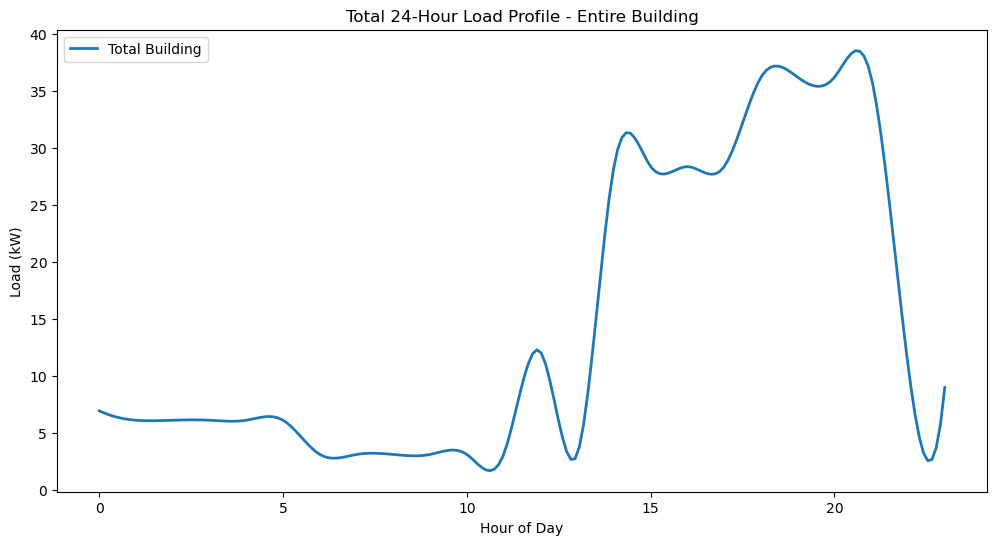

In [5]:
# FUNCTION TO PLOT SMOOTH CURVE
# -----------------------------
def plot_smooth_curve(profile_dict, title, xlabel='Hour of Day', ylabel='Load (kW)'):
    plt.figure(figsize=(12,6))
    x = np.arange(24)
    x_smooth = np.linspace(0, 23, 200)
    for name, profile in profile_dict.items():
        spl = make_interp_spline(x, profile, k=3)  # cubic spline
        y_smooth = spl(x_smooth)
        plt.plot(x_smooth, y_smooth, linewidth=2, label=name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(False)
    plt.legend()
    plt.show()

# -----------------------------
# PLOT PROFILES
# -----------------------------
# 1. Per apartment
plot_smooth_curve(profiles, '24-Hour Load Profile per Apartment')

# 2. Per category (total building)
all_categories = set()
for apt_cats in category_profiles.values():
    all_categories.update(apt_cats.keys())

total_category_profile = {cat: np.zeros(24) for cat in all_categories}
for apt_cats in category_profiles.values():
    for cat, profile in apt_cats.items():
        total_category_profile[cat] += profile

plot_smooth_curve(total_category_profile, '24-Hour Load Profile by Category - Total Building')

# 3. Total building profile
total_building_profile = sum(profiles.values())
plot_smooth_curve({'Total Building': total_building_profile}, 'Total 24-Hour Load Profile - Entire Building')